In [2]:
import sys
sys.path.append('../..')
from src.pomdp import *

import cv2

In [3]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(2)

# Gathering model and solution

In [4]:
model = Model.load_from_file('./Models/Alt_Wrap_GroundAir.pck')
vf = ValueFunction.load_from_file('./Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/ValueFunctions/run-3-VF.gzip', model)

# Get source stats

In [5]:
points_per_unit = 30
env_x = [-2,10]
env_y = [-1,1]

width = ((env_x[1] - env_x[0]) * points_per_unit) + 1
height = ((env_y[1] - env_y[0]) * points_per_unit) + 1

env_shape = [height, width]

In [6]:
# Data loading
def get_data(dx_mod:float=1.0, dy_mod:float=1.0):
    nose_data = pd.read_csv('./Data/statistics_abs_nose_3e6.dat', sep=' ', skiprows=[0], names=list(range(320)), index_col=False).to_numpy().T
    ground_data = pd.read_csv('./Data/statistics_abs_ground_3e6.dat', sep=' ', skiprows=[0], names=list(range(320)), index_col=False).to_numpy().T
    
    dx = int((4 * points_per_unit) * dx_mod)
    dx += 1 if dx % 2 == 0 else 0

    dy = int((points_per_unit) * dy_mod)
    dy += 1 if dy % 2 == 0 else 0

    top_y = int(points_per_unit - ((dy-1) / 2))

    nose_data = cv2.resize(nose_data, dsize=(dx, dy))
    ground_data = cv2.resize(ground_data, dsize=(dx, dy))

    nose_data_padded = np.zeros(env_shape)
    nose_data_padded[top_y:top_y+dy, 60:60+dx] = nose_data

    ground_data_padded = np.zeros(env_shape)
    ground_data_padded[top_y:top_y+dy, 60:60+dx] = ground_data

    nose_data = nose_data_padded
    ground_data = ground_data_padded

    return nose_data, ground_data

In [7]:
nose_data, ground_data = get_data(1,0.1)

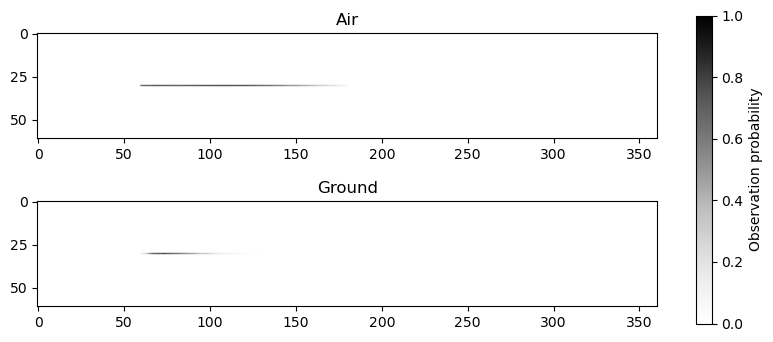

In [8]:
fig, (ax_a, ax_g) = plt.subplots(2, 1, figsize=(10,4))

min_x = 60
min_y = 15
width = 8.5*30
height = 30

ax_a.set_title('Air')
im = ax_a.imshow(nose_data, vmax=1, vmin=0, cmap='Greys')

ax_g.set_title('Ground')
im = ax_g.imshow(ground_data, vmax=1, vmin=0, cmap='Greys')

cbar = plt.colorbar(im, ax=[ax_g,ax_a])
cbar.set_label('Observation probability')

# Visualize possible variations

In [10]:
changes = [i/10 for i in range(2,19,8)]

change_sets = []
for c_x in changes:
    for c_y in changes:
        change_sets.append([c_x, c_y])

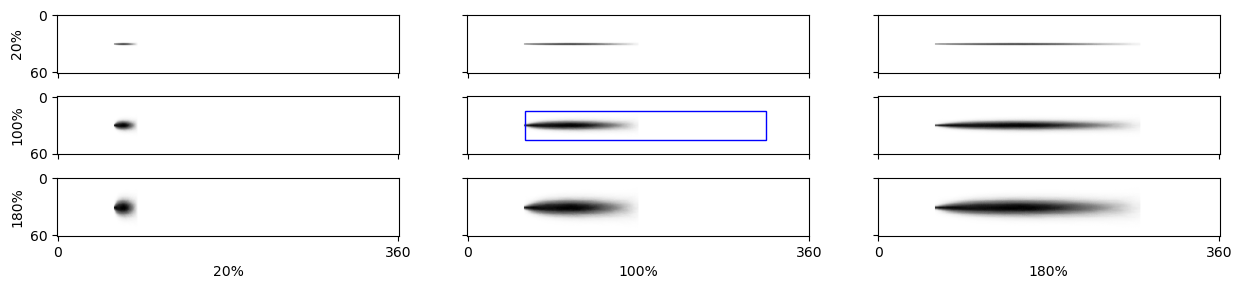

In [16]:
fig, axes = plt.subplots(3,3, figsize=(15,3), sharex=True, sharey=True)
ax_list = axes.T.ravel()

for ax, (x_change, y_change) in zip(ax_list, change_sets):
    nose_data, _ = get_data(x_change, y_change)

    ax.imshow(nose_data, cmap='Greys')

    if x_change == 1.0 and y_change == 1.0:
        ax.add_patch(Rectangle([60, 15], width=8.5*30, height=30, linewidth=1, edgecolor='b', facecolor='none', label='Starting zone'))

    ax.set_xticks([0,360])
    if y_change == 1.8:
        ax.set_xlabel(f'{int(x_change*100)}%')
    
    ax.set_yticks([0,60])
    if x_change == 0.2:
        ax.set_ylabel(f'{int(y_change*100)}%')

In [11]:
change_sets

[[0.2, 0.2],
 [0.2, 1.0],
 [0.2, 1.8],
 [1.0, 0.2],
 [1.0, 1.0],
 [1.0, 1.8],
 [1.8, 0.2],
 [1.8, 1.0],
 [1.8, 1.8]]

# Alt olf probability simulation

In [68]:
class AltSimulationSet(SimulationSet):
    def __init__(self, model:Model, alt_air:np.ndarray, alt_ground:np.ndarray):
        self.alt_air = alt_air.ravel()
        self.alt_ground = alt_ground.ravel()
        super().__init__(model)

    
    def run_actions(self, actions:np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        rewards,_ =  super().run_actions(actions)

        # GPU support
        xp = np if not self.model.is_on_gpu else cp

        # Generate observations
        obs_probs = xp.where(actions == 5, self.alt_air[self.agent_states], self.alt_ground[self.agent_states])
        observations = (xp.random.random(self.n) < obs_probs).astype(int)

        # Check if at goal
        observations = xp.where(xp.isin(self.agent_states, xp.array(self.model.end_states)), 2, observations)

        return rewards, observations

In [16]:
model = model.gpu_model
value_function = vf.to_gpu()

# Grid test

In [11]:
zone = None
cell_size = 10
points_per_cell = 10

In [12]:
model = value_function.model

# Getting grid zone
min_x = None
max_x = None
min_y = None
max_y = None

if zone is None:
    start_coords = np.array(model.cpu_model.get_coords(model.cpu_model.states[model.cpu_model.start_probabilities > 0]))
    (min_x, max_x) = (np.min(start_coords[:,1]), np.max(start_coords[:,1]))
    (min_y, max_y) = (np.min(start_coords[:,0]), np.max(start_coords[:,0]))
else:
    ((min_x,max_x),(min_y,max_y)) = zone

# Generation of points
random_points = []
cell_centers_x = []
cell_centers_y = []

for i in range(min_y, max_y, cell_size):
    for j in range(min_x, max_x, cell_size):
        cell_centers_x.append((j + min([max_x, j+cell_size])) / 2)
        cell_centers_y.append((i + min([max_y, i+cell_size])) / 2)

        for _ in range(points_per_cell):
            rand_x = np.random.randint(j, min([max_x, j+cell_size]))
            rand_y = np.random.randint(i, min([max_y, i+cell_size]))

            random_points.append([rand_x, rand_y])

rand_points_array = np.array(random_points)

points_df = pd.DataFrame(rand_points_array, columns=['x','y'])

# # Cells
points_df['cell'] = np.repeat(np.arange(len(points_df)/points_per_cell, dtype=int), points_per_cell)
points_df['cell_x'] = np.repeat(np.array(cell_centers_x), points_per_cell)
points_df['cell_y'] = np.repeat(np.array(cell_centers_y), points_per_cell)

# Traj and ids
goal_state_coords = model.get_coords(model.end_states[0])
points_df['opt_traj'] = np.abs(goal_state_coords[1] - rand_points_array[:,0]) + np.abs(goal_state_coords[0] - rand_points_array[:,1])
points_df['point_id'] = (model.state_grid.shape[1] * rand_points_array[:,1]) + rand_points_array[:,0]

# Run simulations

In [71]:
nose_data, ground_data = get_data(0.9,0.9)
a = Agent(model, value_function)

In [72]:
_, all_sim_hist = a.run_n_simulations_parallel(len(rand_points_array),
                                               simulator_set=AltSimulationSet(model, cp.array(nose_data), cp.array(ground_data)),
                                               start_state=points_df['point_id'].to_list(),
                                               print_progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

All 780 simulations done in 130.693s:
	- Simulations reached goal: 780/780 (0 failures)
	- Average step count: 267.0692307692308
	- Average total rewards: 1.0
	- Average discounted rewards (ADR): 0.18395408014736028


In [78]:
np.range

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4,
       1.5, 1.6, 1.7, 1.8])